## How to use this Notebook
The development cycle intended here is to 

1. Init an experiment

2. Reset the model and optimizer

3. Restart wandb

4. Run one epoch

5. Add any new logs for plots, as needed

Then repeat steps 4-5 as needed or 2-5 as needed.


In [1]:
from functools import partial

import torch
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

## Initialize the experiment

In [2]:
# Load the exp
import os
import sys

sys.path.insert(0, os.path.expanduser("~/nta/nupic.research/projects/meta_cl"))

from experiments import CONFIGS

exp_name = "metacl_dendrites2"
config = CONFIGS[exp_name]
exp_cls = config["experiment_class"]
exp = exp_cls()
exp.setup_experiment(config)

INFO:DendritesExperiment:Execution order: {'adapt': ['MetaContinualLearningExperiment.adapt'],
 'clone_model': ['MetaContinualLearningExperiment.clone_model'],
 'complexity_loss': [],
 'create_fast_slow_loaders': ['MetaContinualLearningExperiment.create_fast_slow_loaders'],
 'create_loaders': ['MetaContinualLearningExperiment.create_loaders',
                    'Create loaders for the meta testing phase'],
 'create_model': ['SupervisedExperiment.create_model', 'RezeroWeights'],
 'create_replay_sampler': ['MetaContinualLearningExperiment.create_replay_sampler'],
 'create_sampler': ['MetaContinualLearningExperiment.create_sampler'],
 'create_slow_train_dataloader': ['MetaContinualLearningExperiment.create_slow_train_dataloader'],
 'create_task_sampler': ['MetaContinualLearningExperiment.create_task_sampler'],
 'create_train_dataloader': ['SupervisedExperiment.create_train_dataloader'],
 'create_train_sampler': ['MetaContinualLearningExperiment.create_train_sampler'],
 'create_validation

## Reset the Model, Optimizer, and Wandb
Helpful to start new runs quickly

In [3]:
# Reset the optimizer and model
exp.model.reset_params()

# Configure optimizer
group_decay, group_no_decay = [], []
for module in exp.model.modules():
    for name, param in module.named_parameters(recurse=False):
        if exp.should_decay_parameter(module, name, param, config):
            group_decay.append(param)
        else:
            group_no_decay.append(param)

optimizer_class = config.get("optimizer_class", torch.optim.SGD)
optimizer_args = config.get("optimizer_args", {})
exp.optimizer = optimizer_class([dict(params=group_decay),
                                  dict(params=group_no_decay,
                                       weight_decay=0.)],
                                 **optimizer_args)

# Reset the epoch
exp.current_epoch = 0

In [6]:
import wandb

if wandb.run is not None:
    wandb.join()

wandb.init(name="metacl_dendrites2", project="metacl_dendrites_test", reinit=True)

wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Run One Epoch

Be sure to run **Functions to Run the Model** and **Add Wandb Plots via Hooks** below to define the run functions and desired plots.


[[ 7.17166578e-03  1.26597565e-02 -8.31647962e-03 ... -1.12970844e-02
   2.19237129e-03  1.15099782e-02]
 [ 8.98968987e-03  2.96542747e-03 -1.03747640e-02 ... -3.47367488e-04
  -5.79400919e-04  7.63060199e-03]
 [ 6.05306635e-03  1.51492134e-02 -1.12439096e-02 ... -8.51327181e-03
   2.02114228e-03  7.70116039e-03]
 ...
 [-4.46438417e-03  2.18834020e-02 -3.70922498e-05 ...  4.81407018e-03
  -1.81725398e-02  4.14841063e-03]
 [ 8.79820250e-03  5.70637453e-03 -5.55902021e-03 ... -1.07848831e-02
   1.97236426e-03 -5.86457178e-03]
 [-4.88775317e-04  1.16086286e-02 -6.36933325e-03 ... -1.70418248e-03
  -5.02706366e-03 -3.54889268e-03]]


{'total_correct': 20,
 'total_tested': 84,
 'mean_loss': 9.039420127868652,
 'mean_accuracy': 0.23809523809523808,
 'learning_rate': 0.0001}

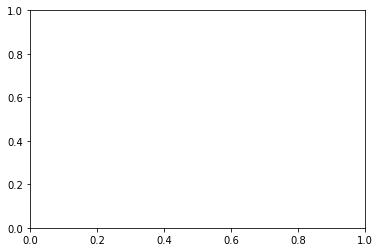

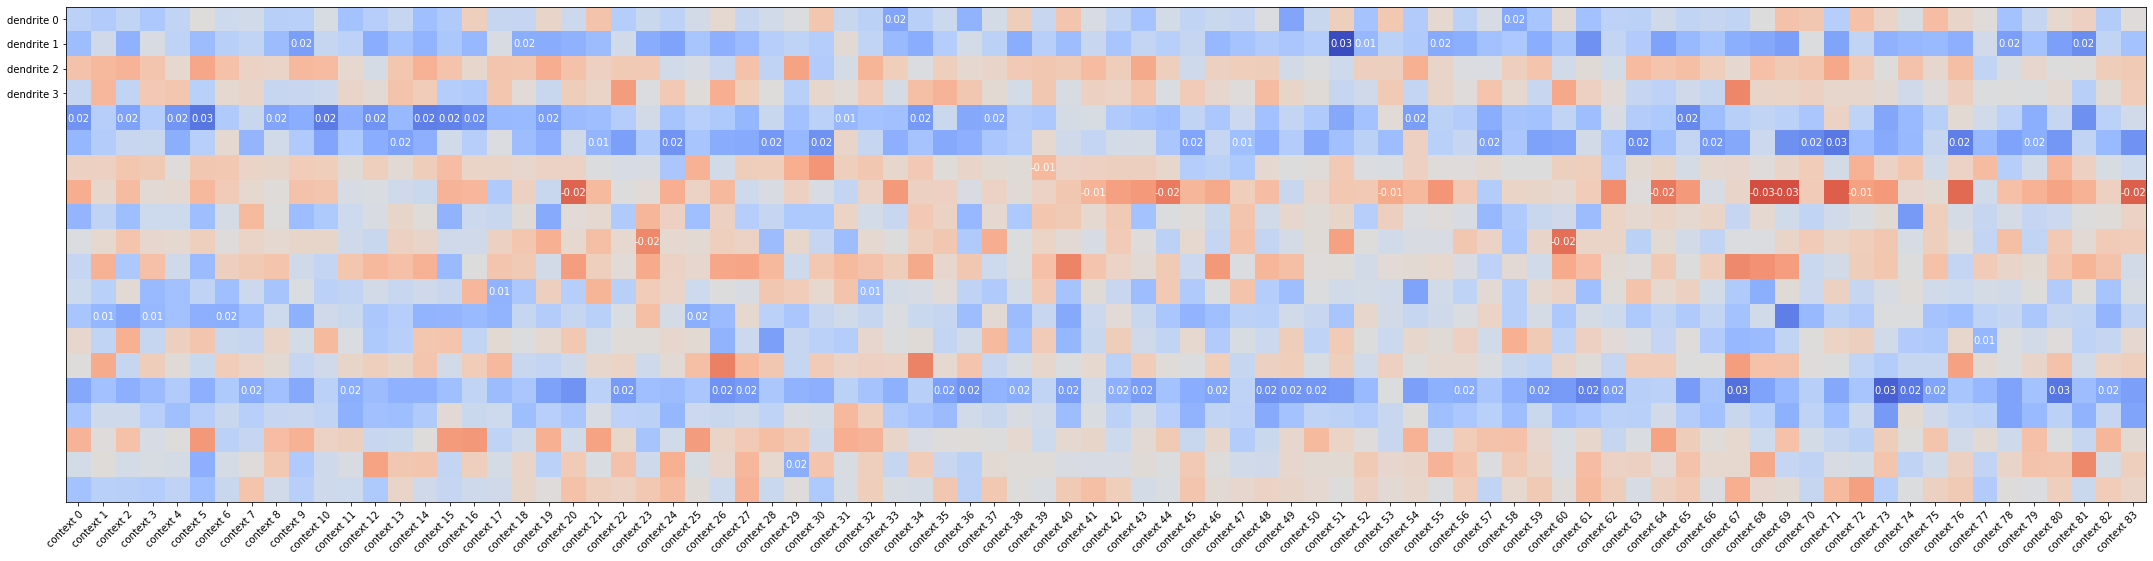

In [12]:
run_epoch(exp)

## Functions to Run the Model


In [8]:
def run_epoch(exp):

    exp.pre_epoch()

    exp.optimizer.zero_grad()

    # Sample tasks for inner loop.
    tasks_train = np.random.choice(
        exp.fast_and_slow_classes,
        size=exp.tasks_per_epoch,
        replace=False
    )

    # Run pre_task; For instance, may reset parameters as needed.
    exp.pre_task(tasks_train)

    # Clone model - clone fast params and the slow params. The latter will be frozen
    cloned_adaptation_net = exp.clone_model()

    # Inner loop: Train over sampled tasks.
    for task in tasks_train:
        run_task(exp, task, cloned_adaptation_net)

    # Sample from the replay set.
    exp.train_replay_loader.sampler.set_active_tasks(exp.replay_classes)
    replay_data, replay_target = next(iter(exp.train_replay_loader))

    # Sample from the slow set.
    slow_data, slow_target = [], []
    for task in tasks_train:
        exp.train_slow_loader.sampler.set_active_tasks(task)
        x, y = next(iter(exp.train_slow_loader))
        slow_data.append(x)
        slow_target.append(y)

    # Concatenate the slow and replay set.
    slow_data = torch.cat(slow_data + [replay_data]).to(exp.device)
    slow_target = torch.cat(slow_target + [replay_target]).to(exp.device)

    # LOGGING
    # cloned_adaptation_net.classifier.register_forward_hook(partial(fhook, name="classifier"))
    cloned_adaptation_net.apply_dendrites = apply_dendrites_and_log

    # Take step for outer loop. This will backprop through to the original
    # slow and fast params.
    output = cloned_adaptation_net(slow_data)
    loss = exp._loss_function(output, slow_target)
    loss.backward()

    exp.optimizer.step()

    # Report statistics for the outer loop
    pred = output.max(1, keepdim=True)[1]
    correct = pred.eq(slow_target.view_as(pred)).sum().item()
    total = output.shape[0]
    results = {
        "total_correct": correct,
        "total_tested": total,
        "mean_loss": loss.item(),
        "mean_accuracy": correct / total if total > 0 else 0,
        "learning_rate": exp.get_lr()[0],
    }
    exp.logger.debug(results)

    exp.post_epoch()

    exp.current_epoch += 1

    return results

In [9]:
def run_task(exp, task, cloned_adaptation_net):
    exp.train_fast_loader.sampler.set_active_tasks(task)

    # Meta-train training. Use no more than `num_fast_steps` sequential updates.
    for i, (data, target) in enumerate(exp.train_fast_loader):
        if i >= exp.num_fast_steps:
            break

        data = data.to(exp.device)
        target = target.to(exp.device)
        train_loss = exp._loss_function(
            cloned_adaptation_net(data), target
        )
        # Update in place
        exp.adapt(cloned_adaptation_net, train_loss)

    # See if there are images to validate on. If 'train_train_sample_size'
    # is equivalent to the number of images per class, then there won't be any.
    if len(exp.val_fast_loader) == 0:
        return

    # Run and log validation for given task.
    with torch.no_grad():
        exp.val_fast_loader.sampler.set_active_tasks(task)

        data, target = next(iter(exp.val_fast_loader))
        data = data.to(exp.device)
        target = target.to(exp.device)

        preds = cloned_adaptation_net(data)
        valid_error = exp._loss_function(preds, target)
        valid_error /= len(data)
        exp.logger.debug(f"Valid error meta train training: {valid_error}")

        # calculate accuracy
        preds = preds.argmax(dim=1).view(target.shape)
        valid_accuracy = (preds == target).sum().float() / target.size(0)
        exp.logger.debug(f"Valid accuracy meta train training: {valid_accuracy}")

## Add Wandb Plots via Hooks

```
DendriticNetwork2(
  (segments): DendriteSegments()
  (classifier): Linear(in_features=2304, out_features=963, bias=True)
  (prediction): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(3, 3))
    (9): Flatten()
  )
  (modulation): Sequential(
    (0): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(3, 3))
    (9): Flatten()
    (10): Linear(in_features=1008, out_features=100, bias=True)
  )
)
```

In [10]:
def fhook(module, x_tuple, y, name=None):
    print(f"NAME: {name} ({module.__class__.__name__})")
    print("  input :", x_tuple[0].shape)
    print("  output:", y.shape)
    print()
    x = x_tuple[0].clone().detach().cpu().numpy()
    wandb.log({
        "pred_modulated_0": wandb.Histogram(x[0, :]),
        "pred_modulated_20": wandb.Histogram(x[20, :]),
        "sparsity_pred_modulated_0": (x[0, :] == 0).sum().item() / len(x[0, :])
    })



In [11]:
def apply_dendrites_and_log(y, dendrite_activations):
    """Apply dendrites as a gating mechanism."""
    # # Multiple by the sigmoid of the max along each segment.
    # return y * torch.sigmoid(dendrite_activations.max(dim=2).values)

    input_dendrite_activations = dendrite_activations.clone()

    inds = dendrite_activations.abs().max(dim=2).indices
    inds = inds.unsqueeze(dim=2)
    dendrite_activations = torch.gather(dendrite_activations, dim=2, index=inds)
    dendrite_activations = dendrite_activations.squeeze(dim=2)
    dendrite_activations = torch.sigmoid(dendrite_activations)

    out = y * dendrite_activations

    log_modulated(y, out, input_dendrite_activations)

    return out

def log_modulated(pre_modulated, post_modulated, input_dendrite_activations):

    pre_modulated = to_numpy(pre_modulated)
    post_modulated = to_numpy(post_modulated)
    input_dendrite_activations = to_numpy(input_dendrite_activations)

    print(input_dendrite_activations[:, 0, :])

    wandb.log({
        # Pre-modulated values
        "pre_modulated_0": wandb.Histogram(pre_modulated[0, :]),
        "pre_modulated_20": wandb.Histogram(pre_modulated[20, :]),
        "sparsity_pre_modulated": (pre_modulated == 0).sum().item() / len(pre_modulated.flatten()),

        # Post-modulated values
        "post_modulated_0": wandb.Histogram(post_modulated[0, :]),
        "post_modulated_20": wandb.Histogram(post_modulated[20, :]),
        "sparsity_post_modulated": (post_modulated == 0).sum().item() / len(post_modulated.flatten()),

        # Dendrite activations
        "dendrite_activation_unit_0": plot_dendrite_activations(input_dendrite_activations[:, 0, :]),
    })


def plot_dendrite_activations(dendrite_activations):
    plt.cla()

    activations = dendrite_activations.transpose(1, 0)[:, 0:84]

    num_contexts = 84
    num_dendrites = 4

    x_labels = [
        "context {}".format(j) for j in range(num_contexts)
    ]
    y_labels = ["dendrite {}".format(j) for j in range(num_dendrites)]

    # Find the range of activation values to anchor the colorbar
    vmax = np.abs(activations).max()
    vmin = -1.0 * vmax

    # Use matplotlib to plot the activation heatmap
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.imshow(activations, cmap="coolwarm_r", vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(num_contexts))
    ax.set_yticks(np.arange(num_dendrites))

    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()

    # Annotate just the top absolute activation for each context
    top_activation_dendrite_per_context = np.argmax(np.abs(activations), axis=0)
    for j, i in enumerate(top_activation_dendrite_per_context):
        val = np.round(activations[i, j], 2)
        ax.text(j, i, val, ha="center", va="center", color="w")

    figure = plt.gcf()
    return fig

def to_numpy(tensor):
    return tensor.clone().detach().cpu().numpy()